In [1]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import fraplib as fl
from aicsimageio.readers import CziReader
from cellpose.models import Cellpose
from mpl_interactions import hyperslicer

%matplotlib ipympl

/n/home08/emayrc2016/.conda/envs/segment/lib/python3.11/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [2]:
model = Cellpose(model_type='cyto2', gpu=True)
channels = [[0,0]]

In [3]:
n = '240201'

In [4]:
p = '/n/gaudet_lab/users/emay/microscopy/'+n+'_LSM880/'
o = p+'out/'

In [5]:
h, _ = fl.batchread(p)
k = list(h.keys())
k.sort()
name = k[0]
name, k

('Image 1.czi', ['Image 1.czi', 'Image 2.czi'])

In [6]:
exptid = [i[:-4] for i in k]
exptid

['Image 1', 'Image 2']

In [7]:
samples = [
    'gC3FL+',
    'mock',
    'gA11dC-',
    'gA11dC+',
    'gC3FL-unstained',
    'gC3FL-',
    'gC3dsdC',
    'gC3ec56',
    'a4dCmCh+',
    '14xdC+', 
    '22xdC+',
    'a4+14x',
    'a4+22x',
    'a4+A11dC-',
    '14x+A11dC-',
    '22x+A11dC-',
]

In [8]:
len(samples)

16

In [9]:
chnames = fl.channel_label(h[name])
chnames

['mCherry', 'Transmitted Light', 'FITC']

In [10]:
images = h[name].asarray().squeeze()
images = np.zeros((np.sum([h[j].asarray().squeeze().shape[0] for j in k]), *images.shape[1:]))
# placer = []
for j, expt in enumerate(k):
    print(expt)
    ims = h[expt].asarray().squeeze()
    # placer.append((j,ims.shape[0]))
    # if len(placer) > 1:
    #     images[placer[j-1][-1]:placer[j-1][-1]+placer[j][-1],...] = ims
    # else:
    #     images[placer[j][0]:placer[j][-1],...] = ims
    images[ims.shape[0]*j:ims.shape[0]*(j+1),...] = ims
images.shape

Image 1.czi
Image 2.czi


(48, 3, 2048, 2048)

In [11]:
chnames.index('Transmitted Light')

1

In [12]:
bfs = images[:,chnames.index('Transmitted Light')]
bfs.shape

(48, 2048, 2048)

In [13]:
reps = 3

ximages = xr.DataArray(
    images.reshape(int(images.shape[0]/reps),reps,*images.shape[-3:]), 
    dims = list('SRCYX'), 
    coords = { 'S' : samples, 'C' : chnames } )

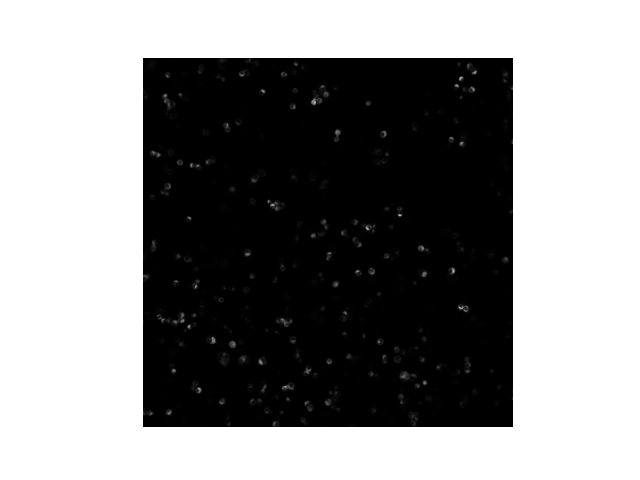

In [14]:
fig, ax = plt.subplots()
# hyperslicer(ximages, cmap = 'gray', vmin = 0, vmax = 2**16)
hyperslicer(ximages, cmap = 'gray')
ax.axis('off')
plt.show()

In [15]:
# normalize by subtracting the min and dividing by max-min
imstack = bfs
norm = (imstack - imstack.min(axis = (-1, -2), keepdims = True))/(imstack.max(axis = (-1, -2), keepdims = True) - imstack.min(axis = (-1, -2), keepdims = True))
norm.dtype

dtype('float64')

In [16]:
image_list = [*norm]
len(image_list)

48

In [17]:
size = 35
masks, flows, styles = model.cp.eval(                                                                                      
    image_list,                                                                                                                  
    batch_size=64,                                                                                                    
    channels=channels,                                                                                                           
    diameter=35,                                                                                                                 
    flow_threshold=0.6,                                                                                                          
    cellprob_threshold=-1,                                                                                                       
    normalize=False,                                                                                                             
)
labels = np.array(masks)

In [18]:
print(n)
print(samples)

240201
['gC3FL+', 'mock', 'gA11dC-', 'gA11dC+', 'gC3FL-unstained', 'gC3FL-', 'gC3dsdC', 'gC3ec56', 'a4dCmCh+', '14xdC+', '22xdC+', 'a4+14x', 'a4+22x', 'a4+A11dC-', '14x+A11dC-', '22x+A11dC-']


In [19]:
labels_cmap = plt.cm.viridis.copy()
labels_cmap.set_under(alpha = 0)

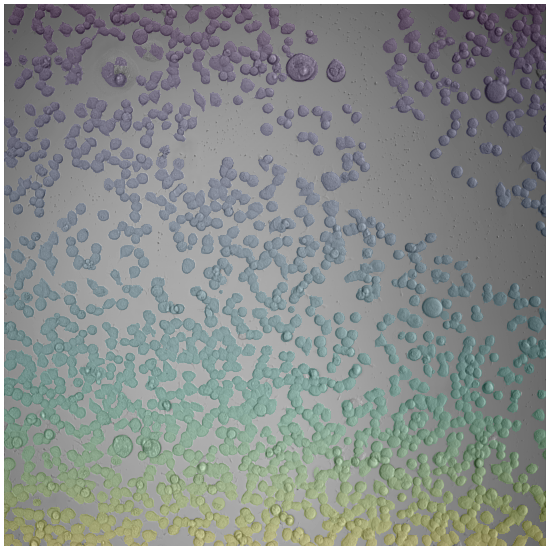

In [20]:
fig, ax = plt.subplots(layout = 'constrained', figsize = (5.5,5.5))
c = hyperslicer(bfs, cmap = 'gray')
hyperslicer(masks, cmap = labels_cmap, vmin = 1, alpha = 0.25, interpolation = 'none', controls=c, ax = ax)
ax.axis('off')
plt.show()

In [21]:
### remember to make the out directory 

In [22]:
np.save(o+'labels_'+str(n), labels)

In [23]:
import pandas as pd

In [24]:
pd.Series(samples).to_csv(o+'samples_'+n+'.txt', sep = '\n', index = None, header = None)